In [1]:
from datasets import load_dataset
import pandas as pd
dataset = load_dataset("autogluon/chronos_datasets", "m4_weekly")
df = pd.DataFrame(dataset['train'])
print(df.head())

e:\proj\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        id                                          timestamp  \
0  T000000  [1975-08-03 12:00:00, 1975-08-10 12:00:00, 197...   
1  T000001  [1984-04-01 12:00:00, 1984-04-08 12:00:00, 198...   
2  T000002  [1975-06-01 12:00:00, 1975-06-08 12:00:00, 197...   
3  T000003  [1967-07-02 12:00:00, 1967-07-09 12:00:00, 196...   
4  T000004  [1986-08-03 12:00:00, 1986-08-10 12:00:00, 198...   

                                              target category  
0  [1089.2, 1078.91, 1079.88, 1063.58, 1060.61, 1...    Other  
1  [195.928, 194.796, 192.71, 190.288, 188.77, 18...    Other  
2  [258.7, 259.8, 260.2, 260.8, 261.1, 263.1, 264...    Other  
3  [3460.0, 3340.0, 2770.0, 2520.0, 2740.0, 2760....    Other  
4  [4696.0, 4765.0, 4144.0, 3945.0, 4733.0, 4330....    Other  


In [2]:
print(f"shape of df: {df.shape}")

shape of df: (359, 4)


In [3]:
print(f"columns of df: {df.columns.to_list()}")

columns of df: ['id', 'timestamp', 'target', 'category']


In [4]:
print(f"data types: {df.dtypes}")

data types: id           object
timestamp    object
target       object
category     object
dtype: object


In [5]:
print(f"missing values :\n{df.isnull().sum()}")

missing values :
id           0
timestamp    0
target       0
category     0
dtype: int64


In [6]:
#converting to long format
import datasets

def to_pandas(ds: datasets.Dataset) -> "pd.DataFrame":
    """Convert dataset to long data frame format."""
    sequence_columns = [col for col in ds.features if isinstance(ds.features[col], datasets.Sequence)]
    return ds.to_pandas().explode(sequence_columns).infer_objects()

data = to_pandas(dataset['train'])
data

,id,timestamp,target,category
0,T000000,1975-08-03 12:00:00,1089.20,Other
0,T000000,1975-08-10 12:00:00,1078.91,Other
0,T000000,1975-08-17 12:00:00,1079.88,Other
0,T000000,1975-08-24 12:00:00,1063.58,Other
0,T000000,1975-08-31 12:00:00,1060.61,Other
...,...,...,...,...
358,T000358,2017-09-10 12:00:00,3386.00,Micro
358,T000358,2017-09-17 12:00:00,3627.00,Micro
358,T000358,2017-09-24 12:00:00,3299.00,Micro
358,T000358,2017-10-01 12:00:00,3743.00,Micro


In [7]:
t = df[['timestamp','target']].iloc[0] 

# Do not split S
S = pd.DataFrame( t.target, index=t.timestamp)

# The id of the time series
S['id'] = 1
S = S.reset_index()

In [8]:
from tsfresh.feature_extraction import MinimalFCParameters
features =  MinimalFCParameters()
# add additional features if needed: https://tsfresh.readthedocs.io/en/latest/api/tsfresh.feature_extraction.html
additional = {
    'kurtosis':None}
features.update(additional)



# This is taking features for all of time 
# You should filter to the last N days and then do extract_features
from tsfresh import extract_features

for time_range in [30, 60, 180, ]:
    filtered_time_series = S.iloc[time_range]
    result_for_1_time_range = extract_features(S, column_id="id", column_sort="index", default_fc_parameters=features)

    # Append the results for each time range into a new object
    result_for_1_time_range

Feature Extraction: 100%|██████████| 1/1 [00:03<00:00,  3.13s/it]


In [9]:
result_for_1_time_range

,0__sum_values,0__median,0__mean,0__length,0__standard_deviation,0__variance,0__root_mean_square,0__maximum,0__absolute_maximum,0__minimum,0__kurtosis
1,19606106.67,4392.895,8944.391729,2192.0,10999.09575,1.209801e+08,14176.820896,41304.72,41304.72,1049.32,1.933077


In [10]:
data['id'] = data['id'].str.replace('T','').astype(int)

In [11]:
data = data.drop(columns='category')

In [12]:
data.dtypes

id                    int32
timestamp    datetime64[ns]
target              float64
dtype: object

In [13]:
result_for_all_ids_and_alldates = extract_features(
    data,
    column_id="id",
    column_sort="timestamp",
    default_fc_parameters=MinimalFCParameters()
    )

Feature Extraction:   0%|          | 0/40 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 40/40 [00:03<00:00, 11.82it/s]


In [14]:
result_for_all_ids_and_alldates

,target__sum_values,target__median,target__mean,target__length,target__standard_deviation,target__variance,target__root_mean_square,target__maximum,target__absolute_maximum,target__minimum
0,1.960611e+07,4392.895,8944.391729,2192.0,10999.095750,1.209801e+08,14176.820896,41304.72,41304.72,1049.320
1,1.892440e+06,584.531,1098.339961,1723.0,1159.626742,1.344734e+06,1597.211586,4155.19,4155.19,186.721
2,7.989222e+06,2507.900,3646.381561,2191.0,2605.907085,6.790752e+06,4481.835586,10089.10,10089.10,258.700
3,9.333605e+06,3354.785,3576.093851,2610.0,1155.673787,1.335582e+06,3758.194930,10735.00,10735.00,1330.000
4,5.507312e+06,3108.000,3407.990099,1616.0,1497.075882,2.241236e+06,3722.315504,21215.00,21215.00,1148.000
...,...,...,...,...,...,...,...,...,...,...
354,3.006700e+05,2880.000,3233.010753,93.0,985.815927,9.718330e+05,3379.969167,5448.00,5448.00,1971.000
355,4.019760e+05,4387.000,4322.322581,93.0,782.039079,6.115851e+05,4392.500155,7267.00,7267.00,2405.000
356,3.367430e+05,3521.000,3620.892473,93.0,587.196812,3.448001e+05,3668.196069,5546.00,5546.00,2249.000
357,5.077660e+05,5445.000,5459.849462,93.0,911.822327,8.314200e+05,5535.465302,7770.00,7770.00,3556.000


In [15]:
import numpy as np
df['y'] = df['target'].apply(lambda x: np.array(x[-40:]))

In [16]:
df['y'][0].shape

(40,)

In [17]:
dataset = pd.merge(result_for_all_ids_and_alldates, df[['y']], left_index=True, right_index=True)

In [18]:
y = np.array(dataset['y'].to_list())

In [19]:
X = dataset.iloc[:,list(dataset.columns != 'y')]

In [20]:
X.shape

(359, 10)

In [21]:
y.shape

(359, 40)

In [22]:
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1. Define evaluation metrics
def mean_absolute_percentage_error(y_true, y_pred):
    # Handle division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return {'MAE': mae, 'RMSE': rmse, 'MAPE': mape}

In [23]:
# 2. Set up TimeSeries cross-validation]
tscv = TimeSeriesSplit(n_splits=5)

In [24]:
model = xgb.XGBRegressor(
    n_estimators=100,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [25]:
MAE= []
RMSE= []
MAPE= []
# Since y is 2D (359, 40), we'll flatten it for the model and reshape predictions
X_array = X.values
y_flat = y.reshape(y.shape[0], -1)  # Shape becomes (359, 40)

for train_idx, test_idx in tscv.split(X_array):
    # Split data
    X_train, X_test = X_array[train_idx], X_array[test_idx]
    y_train, y_test = y_flat[train_idx], y_flat[test_idx]
    
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    
    # Evaluate (reshape predictions back to original format for evaluation)
    y_test_reshaped = y_test.reshape(-1, 40)
    y_pred_reshaped = y_pred.reshape(-1, 40)
    
    # Calculate scores
    mae = mean_absolute_error(y_test_reshaped, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_reshaped, y_pred))
    mape = mean_absolute_percentage_error(y_test_reshaped, y_pred)
    
    # Store scores
    RMSE.append(rmse)
    MAE.append(mae)
    MAPE.append(mape)

In [26]:
print("\n=== Cross-Validation Results ===")
print(f"Average RMSE: {np.mean(RMSE):.4f} (±{np.std(RMSE):.4f})")
print(f"Average MAE: {np.mean(MAE):.4f} (±{np.std(MAE):.4f})")
print(f"Average sMAPE: {np.mean(MAPE):.4f} (±{np.std(MAPE):.4f})")


=== Cross-Validation Results ===
Average RMSE: 3135.4997 (±1155.2308)
Average MAE: 1928.9536 (±690.9397)
Average sMAPE: 58.0052 (±18.8954)


In [27]:
# Standardize metrics to [0, 1]
def standardize_metrics(scores):
    min_score, max_score = min(scores), max(scores)
    if min_score == max_score:  # Avoid division by zero
        return [0.5] * len(scores) if min_score != 0 else [0] * len(scores)
    return [(s - min_score) / (max_score - min_score) for s in scores]

rmse_std = standardize_metrics(RMSE)
mae_std = standardize_metrics(MAE)
mape_std = standardize_metrics(MAPE)

print(f"Average RMSE_std: {np.mean(rmse_std):.4f}")
print(f"Average MAE_std: {np.mean(mae_std):.4f}")
print(f"Average MAPE_std: {np.mean(mape_std):.4f}")

Average RMSE_std: 0.6208
Average MAE_std: 0.5700
Average MAPE_std: 0.7094


In [28]:
model.fit(X_array, y_flat)
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance:")
print(feature_importance)

Feature Importance:
                      feature  importance
4  target__standard_deviation    0.526841
6    target__root_mean_square    0.163991
3              target__length    0.116510
7             target__maximum    0.079401
2                target__mean    0.039451
1              target__median    0.025942
9             target__minimum    0.025578
0          target__sum_values    0.022287
5            target__variance    0.000000
8    target__absolute_maximum    0.000000


In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
import matplotlib.pyplot as plt

fig = make_subplots(rows=1, cols=3, 
                    subplot_titles=('MAE Across Folds', 'RMSE Across Folds', 'MAPE Across Folds'))

# MAE plot
fig.add_trace(
    go.Scatter(x=list(range(1, len(MAE) + 1)), y=MAE, mode='lines+markers', name='MAE',
               line=dict(color='blue'), marker=dict(size=8)),
    row=1, col=1
)

# RMSE plot
fig.add_trace(
    go.Scatter(x=list(range(1, len(RMSE) + 1)), y=RMSE, mode='lines+markers', name='RMSE',
               line=dict(color='green'), marker=dict(size=8)),
    row=1, col=2
)

# MAPE plot
fig.add_trace(
    go.Scatter(x=list(range(1, len(MAPE) + 1)), y=MAPE, mode='lines+markers', name='MAPE',
               line=dict(color='red'), marker=dict(size=8)),
    row=1, col=3
)

fig.update_layout(height=400, width=1200, title_text="Cross-Validation Metrics Across Folds")
fig.update_xaxes(title_text="Fold", row=1, col=1)
fig.update_xaxes(title_text="Fold", row=1, col=2)
fig.update_xaxes(title_text="Fold", row=1, col=3)
fig.update_yaxes(title_text="MAE", row=1, col=1)
fig.update_yaxes(title_text="RMSE", row=1, col=2)
fig.update_yaxes(title_text="MAPE (%)", row=1, col=3)
fig.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_19276\1782856955.py:2: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




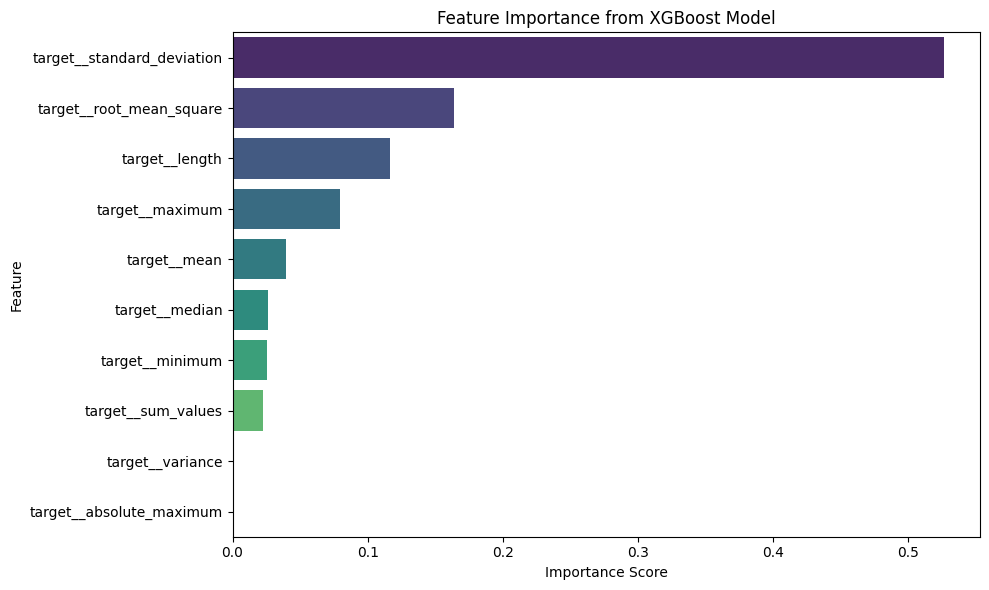

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance, palette='viridis')
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [31]:
# Cell 40: Final Model Training
final_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

# Fit on all data
final_model.fit(X_array, y_flat)
y_pred_all = final_model.predict(X_array).reshape(-1, 40)

In [32]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(range(40)), y=y[-1], mode='lines+markers',
               name='Actual', line=dict(color='blue'), marker=dict(size=8))
)

fig.add_trace(
    go.Scatter(x=list(range(40)), y=y_pred_all[-1], mode='lines+markers',
               name='Predicted', line=dict(color='red', dash='dash'), marker=dict(size=8))
)

fig.update_layout(
    height=500,
    width=800,
    title_text="Actual vs Predicted Values (Last Series)",
    xaxis_title="Time Step",
    yaxis_title="Value",
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)
fig.show()

In [33]:
fig = make_subplots(rows=3, cols=1, subplot_titles=['Series 0', 'Series 1', 'Series 2'])

for i in range(3):
    fig.add_trace(
        go.Scatter(x=list(range(40)), y=y[i], mode='lines+markers',
                  name=f'Actual Series {i}', line=dict(color='blue')),
        row=i+1, col=1
    )
    fig.add_trace(
        go.Scatter(x=list(range(40)), y=y_pred_all[i], mode='lines+markers',
                  name=f'Predicted Series {i}', line=dict(color='red', dash='dash')),
        row=i+1, col=1
    )

fig.update_layout(height=900, width=800, title_text="Actual vs Predicted for First 3 Series")
fig.update_xaxes(title_text="Time Step")
fig.update_yaxes(title_text="Value")
fig.show()

In [34]:
final_metrics = evaluate_forecast(y, y_pred_all)
print("\nFinal Model Performance on Full Dataset:")
for metric, value in final_metrics.items():
    print(f"{metric}: {value:.4f}")


Final Model Performance on Full Dataset:
MAE: 98.9754
RMSE: 137.4544
MAPE: 4.7088
